# Model Selection

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = '../results/zinser_results_full.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

## Load, Plot Data

In [3]:
# load processed data
datafile = '../data/size_distribution/zinser_processed.nc'

dataname = 'zinser'

desc = 'Culture dataset'

# Indices of data to hold out for hold-out validation
# Uncomment desired line and set use_testdata to true
# itestfile = '../data/hold_out/keep_twothirds.csv'
# itestfile = '../data/hold_out/keep_half.csv'
# itestfile = '../data/hold_out/keep_onethird.csv'

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]

# create "counts" entry
if 'count' in data_gridded:
    data_gridded['counts'] = (data_gridded['count'][None,:]
                              * data_gridded['w_obs']).astype(int)
elif 'abundance' in data_gridded:
    logging.warning('Using "abundance" data to generate count data for the model.')
    data_gridded['counts'] = (data_gridded['count'][None,:]
                              * data_gridded['w_obs']).astype(int)
else:
    raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafile))


# add description
desc += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded)

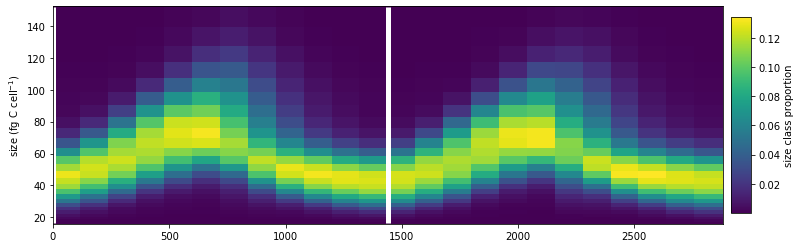

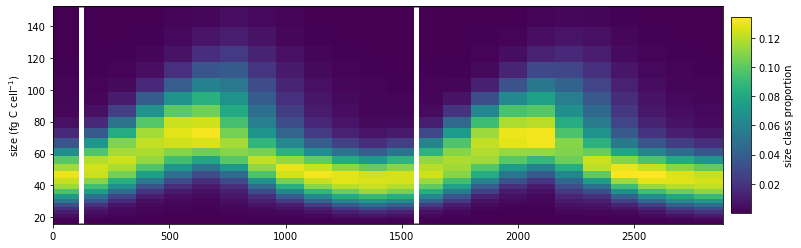

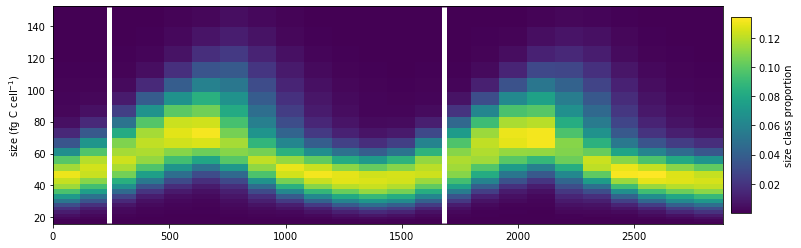

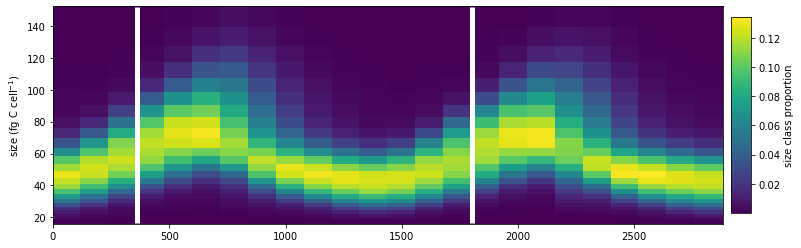

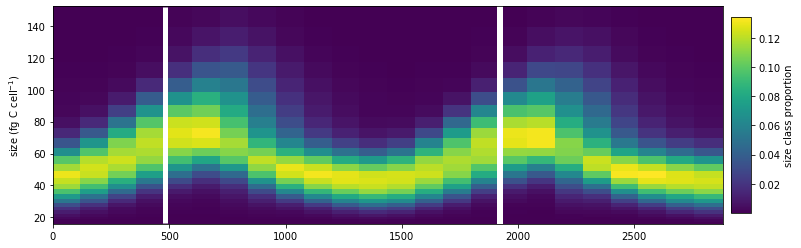

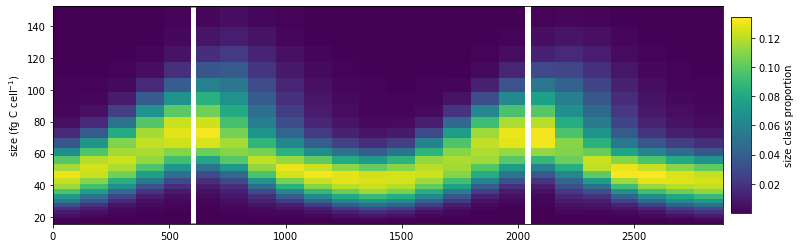

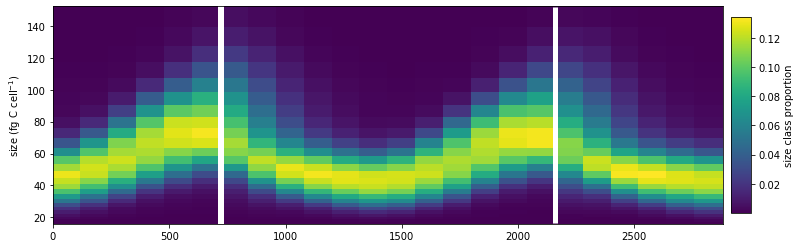

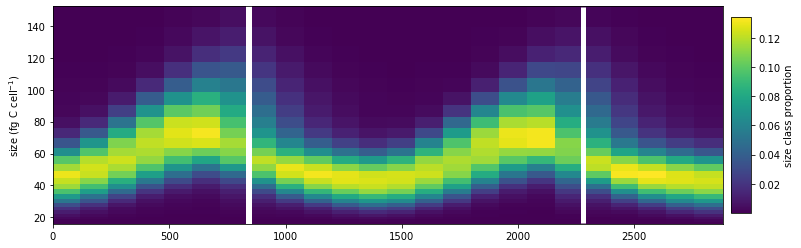

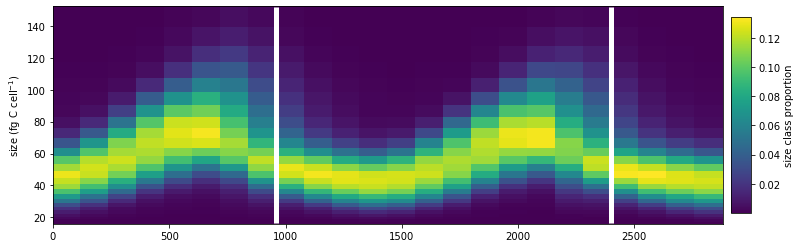

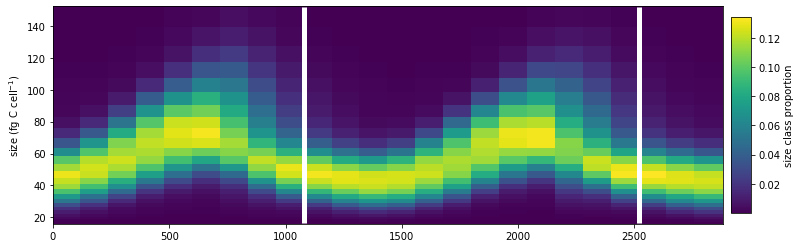

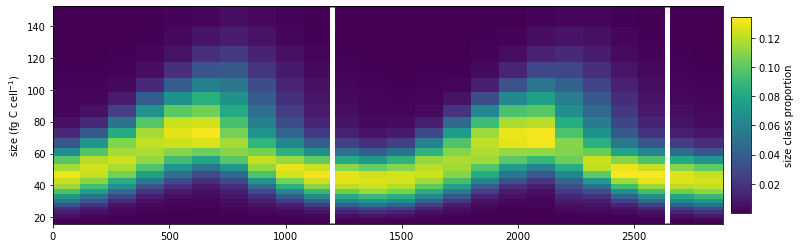

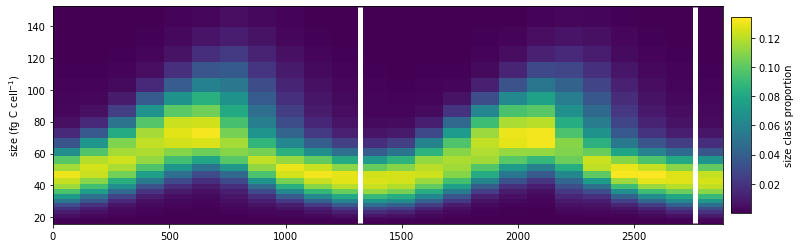

In [17]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5,
                            bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                              **cbarargs)

for start in range(0, 12):
    indices = (start, start+12)
    if show_data:
        nrows = 1

        v_min = data_gridded['v_min']
        delta_v = 1.0/data_gridded['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

        fig,ax = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    #     ax = axs[1]
        pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['w_obs'],
                           shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        for index in indices:
            t = data_gridded['time']
            rect = mpl.patches.Rectangle((t[index],0.005), width=1, ec='white',
                                         height=1-2*0.005, lw=5,fc='none',
                                         transform=ax.get_xaxis_transform())
            ax.add_artist(rect)

    axs[-1].set_xlabel=('time (minutes)')
None

## Process and Re-plot Data

In [5]:
# prepare data for Stan model
if 'data' not in globals():
    data = {}

dt = 20 # in units of minutes

data = {'dt':dt}
for v in ('m','v_min','delta_v_inv'):
    data[v] = data_gridded[v]
    
limit_days = 2

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
par = data_gridded['PAR']

if limit_days > 0:
    limit_minutes = limit_days*1440

    ind_obs = data['t_obs'] < limit_minutes

    if not np.all(ind_obs):
        print('limit_days is set to {}, removing {}/{} observation times'.format(limit_days,
                                                                                 ind_obs.size
                                                                                 -np.count_nonzero(ind_obs),
                                                                                 ind_obs.size))

    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])

data['nt_obs'] = data['t_obs'].size

if use_testdata:
    # load cross-validation testing indices and add them to data
    data['i_test'] = np.loadtxt(itestfile).astype(int)
    # remove last index, so that dimensions agree
    data['i_test'] = data['i_test'][:-1]
else:
    # set all indices to zero
    data['i_test'] = np.zeros(data['nt_obs'], dtype=int)

# switch on or off data fitting
data['prior_only'] = int(prior_only)

# add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=par)

# real count data
data['obs_count'] = data_gridded['counts'][:, ind_obs]

# consistency check
if len(data['i_test']) != data['nt_obs']:
    raise ValueError('Invalid number of testing indices (expected {}, got {}).'.format(data['nt_obs'],
                                                                                       len(data['i_test'])))

limit_days is set to 2, removing 1/25 observation times


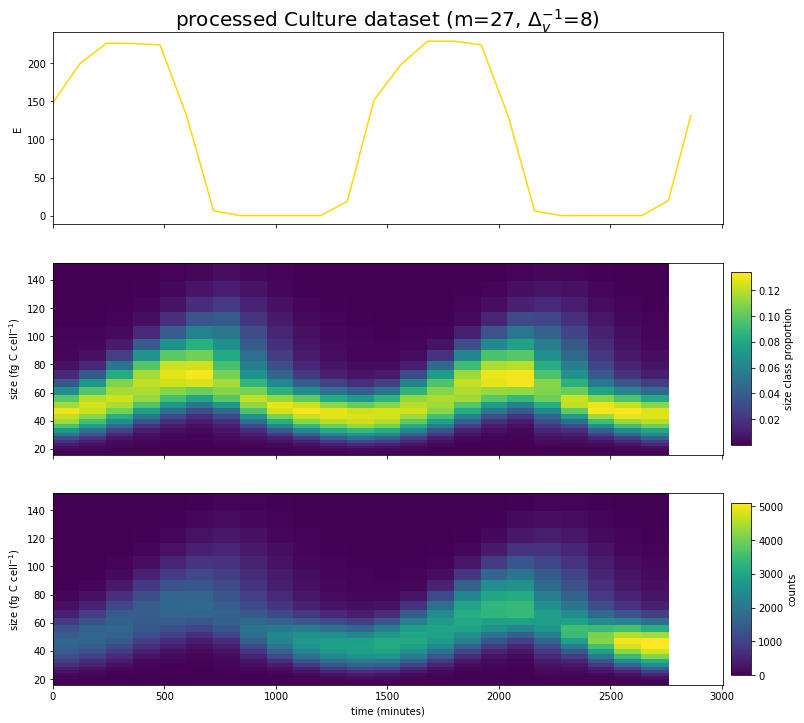

In [6]:
if show_data:
    nrows = 3

    v_min = data['v_min']
    delta_v = 1.0/data['delta_v_inv']
    v = v_min * 2**(np.arange(data['m'])*delta_v) 
    t = np.arange(data['nt'])*data['dt']


    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('processed '+desc, size=20)
    ax.plot(t, data['E'], color='gold')
    ax.set(ylabel='E')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap,
                 label='size class proportion')
    ax.set_xlim(left=0.0)

    ax = axs[2]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs_count'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
None

## Choose models to fit

In [7]:
# Code files
stan_files = {
    'm_bmx': '../stan_code/m_bmx.stan',
    'm_bmb': '../stan_code/m_bmb.stan',
    'm_pmb': '../stan_code/m_pmb.stan',
    'm_fmb': '../stan_code/m_fmb.stan',
    'm_fmf': '../stan_code/m_fmf.stan',
    'm_btb': '../stan_code/m_btb.stan',
    'm_ptb': '../stan_code/m_ptb.stan',
    'm_ftb': '../stan_code/m_ftb.stan',
    'm_ftf': '../stan_code/m_ftf.stan',
}

## Fit Models to the Data

In [8]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key, stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in stan_files.keys():
    code_split = stan_base_code[model].split('\n')
    stan_code[model] = '\n'.join(code_split)

In [9]:
for model in stan_files.keys():
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model],
                                         model_name=model,
                                         obfuscate_model_name=False)

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = []
    if model not in sampling_time:
        sampling_time[model] = []
    if model in mcmcs:
        if not refit_all and not refit_required[model]:
            print('{}: found existing results:'.format(model))
            print('{}'.format(model)) 
            print('\n'.join(x for x in mcmcs[model].__str__().split('\n')
                            if '[' not in x))
            rhat_max = get_max_rhat(mcmcs[model])
            if try_again and rhat_max >= 1.1:
                print('{}: found Rhat={:.3f}, trying again'.format(model,
                                                                   rhat_max))
            else:
                print('{}: not re-running model'.format(model))
                print()
                continue
        elif refit_all:
            print('{}: refit_all is active, re-running model'.format(model))
        elif refit_required[model]:
            print('{}: change in model code requires re-running model'.format(model))
    else:
        mcmcs[model] = {}
    for itry in range(num_tries):
        t0 = time.time()
        mcmcs[model] = models[model].sampling(data=data, iter=2000,
                                              chains=num_chains)
        sampling_time[model].append(time.time() - t0)  # in seconds
        
        # get max Rhat
        rhat_max = get_max_rhat(mcmcs[model])
        maxrhats[model].append(rhat_max)
        print('{}: in try {}/{} found Rhat={:.3f}'.format(model, itry+1,
                                                          num_tries,
                                                          rhat_max), end='')
        if rhat_max < 1.1 or itry == num_tries - 1:
            print()
            break
        print(', trying again')

    print('{}'.format(model)) 
    print('\n'.join(x for x in mcmcs[model].__str__().split('\n')
                    if '[' not in x))
    print()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_bmx NOW.


m_bmx: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_bmb NOW.


m_bmb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_pmb NOW.


m_pmb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_fmb NOW.


m_fmb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_fmf NOW.


m_fmf: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_btb NOW.


m_btb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ptb NOW.


m_ptb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ftb NOW.


m_ftb: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ftf NOW.


m_ftf: compiling


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_bmx: in try 1/3 found Rhat=1.002
m_bmx
Inference for Stan model: m_bmx.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              32.01    0.11   7.02  21.41  26.94  30.87  35.87  48.72   3956    1.0
gamma_max               6.07  5.6e-3   0.39   5.04   5.87   6.18   6.37    6.5   5045    1.0
rho_max                 3.24    0.02   1.89   0.14    1.6   3.22   4.89   6.35  13222    1.0
E_star                418.09    0.55   42.2 319.28 394.38 421.56 446.92 489.97   5816    1.0
sigma                 173.55    0.09   9.91 154.75 166.87 173.35 179.95 193.89  13399    1.0
divrate                 1.06  5.4e-4   0.05   0.97   1.02   1.05   1.09   1.15   7567    1.0
lp__                  -1.4e6    0.42  18.89 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2065    1.0

Samples were drawn using NUTS at Thu Feb 18 12:43:48 2021.
For 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_bmb: in try 1/3 found Rhat=1.002
m_bmb
Inference for Stan model: m_bmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              49.67    0.16   9.71   32.1  42.39  49.05  56.48  69.16   3670    1.0
gamma_max               6.16  5.6e-3    0.3   5.38    6.0   6.25    6.4   6.51   2860    1.0
rho_max                 0.84  3.6e-4   0.03   0.79   0.82   0.84   0.86    0.9   6243    1.0
E_star                 263.6    0.41  21.97 210.85 251.61  267.0 279.02 298.52   2894    1.0
sigma                 348.96    0.21  19.66 311.86 335.45 348.46 362.03 388.54   8887    1.0
divrate                 0.63  2.8e-4   0.02   0.58   0.61   0.63   0.64   0.67   6579    1.0
lp__                  -1.4e6    0.39  18.56 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2267    1.0

Samples were drawn using NUTS at Thu Feb 18 13:08:31 2021.
For 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_pmb: in try 1/3 found Rhat=1.001
m_pmb
Inference for Stan model: m_pmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               7.92    0.02   1.58   5.66   6.82   7.65   8.73   11.7   4094    1.0
gamma_max               6.49  3.1e-4   0.03    6.4   6.47    6.5   6.51   6.52   9748    1.0
rho_max                 1.07  3.3e-4   0.03   1.02   1.05   1.07   1.09   1.12   6035    1.0
E_star                 83.87    0.08   6.52  71.45  79.47  83.66  88.04  97.23   5917    1.0
sigma                 519.45    0.29  29.37 462.51 499.19 519.31 539.32 578.81  10258    1.0
exponent_gamma         -0.55  2.3e-4   0.02  -0.58  -0.56  -0.55  -0.53  -0.51   6388    1.0
divrate                 0.33  2.4e-4   0.02    0.3   0.32   0.33   0.35   0.37   5333    1.0
lp__                  -1.4e6    0.39  18.87 -1.4e6 -1.4e6 -1.4e6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_fmb: in try 1/3 found Rhat=1.004
m_fmb
Inference for Stan model: m_fmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               4.55  9.8e-3   0.65    3.6    4.1   4.46   4.88   6.11   4396    1.0
gamma_mu                4.22  4.3e-3   0.37   3.49   3.97   4.21   4.46   4.94   7357    1.0
gamma_sigma              1.8  3.1e-3   0.28   1.35   1.61   1.77   1.96   2.45   8088    1.0
rho_max                 1.09  3.5e-4   0.03   1.03   1.07   1.09    1.1   1.14   6238    1.0
E_star                121.81    0.21  10.04 103.19 114.95 121.59 128.42 142.36   2363    1.0
sigma                 647.42     0.4   37.0  576.9 622.06 646.63  672.1 722.77   8618    1.0
divrate                 0.29  2.2e-4   0.02   0.26   0.28   0.29    0.3   0.33   5912    1.0
lp__                  -1.4e6    0.42  19.38 -1.4e6 -1.4e6 -1.4e6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_fmf: in try 1/3 found Rhat=3.698, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_fmf: in try 2/3 found Rhat=1.003
m_fmf
Inference for Stan model: m_fmf.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               0.99  4.5e-3   0.25   0.61   0.82   0.96   1.13   1.57   2991    1.0
gamma_mu                4.98  4.9e-3   0.33    4.3   4.76   4.98    5.2   5.63   4600    1.0
gamma_sigma             1.52  3.7e-3   0.26    1.1   1.33   1.49   1.67   2.11   4813    1.0
rho_mu                  1.13  1.6e-3   0.12   0.89   1.05   1.13    1.2   1.36   5337    1.0
rho_sigma               0.54  1.4e-3   0.09   0.39   0.47   0.53   0.59   0.76   4336    1.0
E_star                209.37    0.25    9.7  189.2 203.07 209.84 216.18 226.92   1524    1.0
sigma                 1488.1    1.25  89.56 1318.6 1426.5 1485.7 1548.9 1669.9   5145    1.0
divrate                 0.13  2.4e-4   0.01   0.11   0.12   0.13

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_btb: in try 1/3 found Rhat=16.789, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_btb: in try 2/3 found Rhat=16.397, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_btb: in try 3/3 found Rhat=1.002
m_btb
Inference for Stan model: m_btb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              70.92    0.01   1.05  68.09   70.5  71.22  71.68  71.97   9163    1.0
gamma_max               6.28  3.5e-3   0.22   5.71   6.18   6.34   6.44   6.51   3906    1.0
rho_max                 0.69  1.0e-3   0.06   0.57   0.65   0.69   0.73   0.79   3212    1.0
E_star                262.38    0.37  20.57 221.69 249.18 262.32 275.78  304.1   3157    1.0
sigma                 523.18     0.3   29.2 467.58 503.05 522.56 542.39 582.95   9664    1.0
divrate                 0.85  4.8e-4   0.04   0.77   0.82   0.84   0.87   0.93   6637    1.0
lp__                  -1.4e6    0.38  18.65 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2359    1.0

Samples were drawn using NUTS at Thu Feb 18 18:48:42 2021.
For 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_ptb: in try 1/3 found Rhat=1.001
m_ptb
Inference for Stan model: m_ptb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              48.48    0.15   7.19  36.91  43.39  47.47  52.58  65.32   2151    1.0
gamma_max               6.39  1.2e-3   0.12   6.08   6.34   6.42   6.48   6.51   8803    1.0
rho_max               5.6e-3  5.2e-5 5.4e-3 1.3e-4 1.7e-3 4.1e-3 7.8e-3   0.02  11155    1.0
E_star                164.25    0.15   12.6 140.67 155.48 163.91 172.35 190.18   7495    1.0
sigma                 1473.3    0.93  86.03 1310.4 1415.4 1470.9 1529.7 1648.5   8601    1.0
exponent_gamma         -0.71  2.5e-4   0.02  -0.75  -0.72  -0.71  -0.69  -0.67   7808    1.0
divrate                 0.95  1.9e-4   0.02   0.91   0.93   0.95   0.96   0.98   8013    1.0
lp__                  -1.4e6    0.43  19.04 -1.4e6 -1.4e6 -1.4e6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_ftb: in try 1/3 found Rhat=1.010
m_ftb
Inference for Stan model: m_ftb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              34.57     0.1   4.28  27.91  31.61  34.03  36.85  44.62   1836    1.0
gamma_mu                3.96    0.01    0.4   3.18    3.7   3.96   4.23   4.73   1295    1.0
gamma_sigma             1.63  3.9e-3   0.26   1.19   1.44    1.6   1.78   2.21   4676    1.0
rho_max                 0.05  5.1e-4   0.03 3.3e-3   0.03   0.05   0.07   0.12   3802    1.0
E_star                286.58    1.12  26.19 232.79 269.05 288.46 305.27 332.74    543   1.01
sigma                 1766.2    1.17 103.22 1571.2 1696.5 1763.4 1834.4 1977.0   7724    1.0
divrate                  0.9  3.3e-4   0.03   0.85   0.89    0.9   0.92   0.95   5790    1.0
lp__                  -1.4e6    0.43  19.38 -1.4e6 -1.4e6 -1.4e6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m_ftf: in try 1/3 found Rhat=1.015
m_ftf
Inference for Stan model: m_ftf.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              14.95    0.04   1.68  12.33  13.77   14.7  15.89  18.77   2287    1.0
gamma_mu                4.49  6.2e-3   0.37   3.75   4.24    4.5   4.74    5.2   3581    1.0
gamma_sigma             1.76  3.8e-3   0.27   1.32   1.57   1.74   1.92   2.38   5185    1.0
rho_mu                  0.45  1.3e-3   0.07   0.32    0.4   0.45    0.5   0.58   2785    1.0
rho_sigma                0.3  8.3e-4   0.05   0.22   0.27    0.3   0.33   0.42   3786    1.0
E_star                293.33    0.52  13.95  263.3 284.57 294.34  302.9 318.29    727   1.01
sigma                 3905.5    4.24 270.69 3401.9 3719.8 3894.3 4080.3 4475.9   4072    1.0
divrate                 0.47  6.1e-4   0.02   0.44   0.46   0.47

## Save Results

In [23]:
if 'varnames_save' not in globals():
    varnames_save = None

save_only_converged = True

if savename_output is not None:
    with nc4.Dataset(savename_output, 'w') as nc:
        if save_stan_output:
            dimensions = {
                'obstime':int(data['nt_obs']),
                'time':int(data['nt']),
                'sizeclass':int(data['m']),
                'm_minus_j_plus_1':int(data['m']-data['delta_v_inv']),
                'm_minus_1':int(data['m']-1),
                'knots_minus_1':int(6-1),  # hardcoded, adjust for varying nknots
            }
            dimensions_inv = {v:k for k,v in dimensions.items()}
            
            for imodel, model in enumerate(mcmcs):
                if save_only_converged and get_max_rhat(mcmcs[model]) > 1.1:
                    logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                    continue
                ncm = nc.createGroup(model)
                
                for d in dimensions:
                    ncm.createDimension(d, dimensions[d])
                
                if 'sample' not in dimensions:
                    dimensions['sample'] = mcmcs[model]['mod_obspos'].shape[0]
                    dimensions_inv[dimensions['sample']] = 'sample'
                    ncm.createDimension('sample', dimensions['sample'])
                if 'tau[1]' in mcmcs[model].flatnames and 'tau' not in dimensions:
                    dimensions['tau'] = mcmcs[model]['tau'].shape[1]
                    dimensions_inv[dimensions['tau']] = 'tau'
                    ncm.createDimension('tau', dimensions['tau'])
                
                ncm.createVariable('time', int, ('time',))
                ncm.variables['time'][:] = int(data['dt']) * np.arange(data['nt'])
                ncm.variables['time'].units = 'minutes since start of experiment'

                ncm.createVariable('obstime', int, ('obstime',))
                ncm.variables['obstime'][:] = data['t_obs'].astype(int)
                ncm.variables['obstime'].units = 'minutes since start of experiment'
                ncm.variables['obstime'].long_name = 'time of observations'
                
                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test',
                      'E', 'obs_count'):
                    if isinstance(data[v], int):
                        ncm.createVariable(v, int, zlib=True)
                        ncm.variables[v][:] = data[v]
                    elif isinstance(data[v], float):
                        ncm.createVariable(v, float, zlib=True)
                        ncm.variables[v][:] = data[v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[v].shape)
                        ncm.createVariable(v, data[v].dtype, dims, zlib=True)
                        ncm.variables[v][:] = data[v]

                # write model description
                ncm.setncattr('code', stan_files[model])

                varnames = set(v.split('[')[0] for v in mcmcs[model].flatnames)
                if varnames_save is None:
                    varnames_curr = varnames
                else:
                    varnames_curr = varnames_save

                for v in varnames_curr:
                    if v in varnames:
                        dims = tuple(dimensions_inv[d]
                                     for d in mcmcs[model][v].shape)
                        ncm.createVariable(v, float, dims, zlib=True)
                        ncm.variables[v][:] = mcmcs[model][v]
                    else:
                        logging.warning('Cannot find variable "{}" for model "{}".'.format(v,
                                                                                           model))

        else:
            for i,model in enumerate(mcmcs):
                ncm = nc.createGroup(model)
                if i == 0:
                    ncm.createDimension('model', len(mcmcs))
                    ncm.createDimension('sample',
                                        mcmcs[model]['divrate'].shape[0])

                    ncm.createVariable('divrate', float, ('model','sample'))
                    ncm.createVariable('sumsqdiff', float, ('model','sample'))
                    ncm.variables['sumsqdiff'].setncattr('long_name',
                                                         'sum of squared column differences')

                ncm.variables['divrate'][i,:] = mcmcs[model]['divrate']

                obs = data['obs']

                tmp = mcmcs[model]['mod_obspos']
                tmp/= np.sum(tmp, axis=1)[:, None, :]
                tmp -= obs[None, :, :]
                tmp **= 2

                if np.all(data['i_test'] == 0):
                    ncm.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1),
                                                              axis=1)
                    if i == 0:
                        ncm.variables['sumsqdiff'].setncattr('data_used',
                                                             'all data')
                else:
                    nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:, :, data['i_test'] == 1],
                                                                    axis=1), axis=1)
                    if i == 0:
                        ncm.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                for iv,v in enumerate(('gamma_max', 'rho_max', 'xi',
                                       'xir', 'E_star')):
                    if i == 0:
                        ncm.createVariable(v, float, ('model','sample'))
                    if v in mcmcs[model].flatnames:
                        ncm.variables[v][i,:] = mcmcs[model][v]